In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(3680, 24)
(3680, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where RL swings
idxs = np.where(X_motion[:, -1] == 1)[0]
X_motion_RL_swinging = X_motion[idxs]
Y_motion_RL_swinging = Y_motion[idxs]

## Predict RL foot -> x

In [8]:
X_motion_RL_swinging[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.24255066,  0.12988332, -0.36641276,  0.24385893,
       -0.12947911, -0.37880677, -0.25405625,  0.13502544, -0.38474333,
       -0.25616899, -0.12478851, -0.3675423 ,  0.01024288, -0.00689721,
       -0.01041653,  0.02159023,  0.        ,  1.        ])

In [9]:
X_motion_RL_swinging[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.24255066,  0.12988332, -0.36641276,  0.24385893,
       -0.12947911, -0.37880677, -0.25405625,  0.13502544, -0.38474333,
       -0.25616899, -0.12478851, -0.3675423 ,  0.01024288, -0.00689721,
       -0.01041653,  0.02159023,  0.        ,  1.        ])

### Linear Regression

In [20]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # Previous motion command
               X_motion_RL_swinging[:, 3:6], # Current motion command
               #X_motion_RL_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_RL_swinging[:, 6:8], # FL (x,y) position
               X_motion_RL_swinging[:, 9:11], # FR (x,y) position
               X_motion_RL_swinging[:, 12:14], # RL (x,y) position
               X_motion_RL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_x = LinearRegression()

# Fit the model
model_rl_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9475836272821692
RMSE:  0.033445765595679654
The lowest error is:  0.00011470998495144435
The highest error is:  0.43498684272324706
The avg. error is:  0.018766288236794174


In [21]:
model_rl_relative_swinging_x.coef_

array([[ 1.70366218e-02, -1.11022302e-16, -3.33066907e-16,
         2.46987747e-01,  0.00000000e+00,  2.22044605e-16,
         2.17283985e+00, -1.34653939e+00,  5.08311672e-01,
         1.19941330e+00, -2.62335561e+00,  6.64897183e-01,
        -1.68022444e+00,  1.01955256e+00]])

In [22]:
model_rl_relative_swinging_x.intercept_

array([-1.39231793])

Text(0, 0.5, 'Predictions')

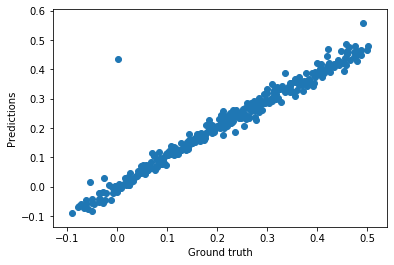

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict RL foot -> y

In [23]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # Previous motion command
               X_motion_RL_swinging[:, 3:6], # Current motion command
               #X_motion_RL_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_RL_swinging[:, 6:8], # FL (x,y) position
               X_motion_RL_swinging[:, 9:11], # FR (x,y) position
               X_motion_RL_swinging[:, 12:14], # RL (x,y) position
               X_motion_RL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_y = LinearRegression()

# Fit the model
model_rl_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.552192736238676
RMSE:  0.008114304560015623
The lowest error is:  9.053656263136034e-06
The highest error is:  0.04717758681207429
The avg. error is:  0.005898267055874707


In [24]:
model_rl_relative_swinging_y.coef_

array([[ 2.03375730e-03, -4.16984156e-16,  1.38777878e-16,
        -1.26726550e-02,  2.22044605e-16, -2.22044605e-16,
        -5.12280764e-01,  3.21886936e-01, -1.85506939e-01,
        -8.96773691e-01,  3.93966306e-01, -1.24265884e+00,
         6.75808751e-01,  5.71400241e-01]])

In [25]:
model_rl_relative_swinging_y.intercept_

array([0.52675242])

Text(0, 0.5, 'Predictions')

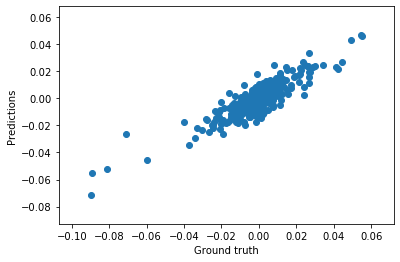

In [18]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [19]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')